## Dependencies

In [1]:
!pip install --quiet efficientnet

In [2]:
import warnings, json, re
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 1024,
  "EPOCHS": 40,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "BASE_MODEL_PATH": base_model_path + 'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 1024,
 'EPOCHS': 40,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': '/kaggle/input/efficientnet/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## Auxiliar functions

In [6]:
# Datasets utility functions
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64), # shape [] means single element
    "image_name": tf.io.FixedLenFeature([], tf.string),
    # meta features
    "patient_id": tf.io.FixedLenFeature([], tf.int64),
    "sex": tf.io.FixedLenFeature([], tf.int64),
    "age_approx": tf.io.FixedLenFeature([], tf.int64),
    "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
    "diagnosis": tf.io.FixedLenFeature([], tf.int64)
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)


def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'], seed=SEED)
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'], seed=SEED)
        
    if p_crop >= .7: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.6), int(config['WIDTH']*.6), config['CHANNELS']], seed=SEED)
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']], seed=SEED)
        elif p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']], seed=SEED)
        else:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']], seed=SEED)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])
    
        
    ## Pixel-level transforms
    if p_pixel >= .4: # pixel transformations
        if p_pixel >= .85:
            image['input_image'] = tf.image.random_saturation(image['input_image'], lower=0, upper=2, seed=SEED)
        elif p_pixel >= .65:
            image['input_image'] = tf.image.random_contrast(image['input_image'], lower=.8, upper=2, seed=SEED)
        elif p_pixel >= .5:
            image['input_image'] = tf.image.random_brightness(image['input_image'], max_delta=.2, seed=SEED)
        else:
            image['input_image'] = tf.image.adjust_gamma(image['input_image'], gamma=.5)

    return image, label


def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 8.57e-06


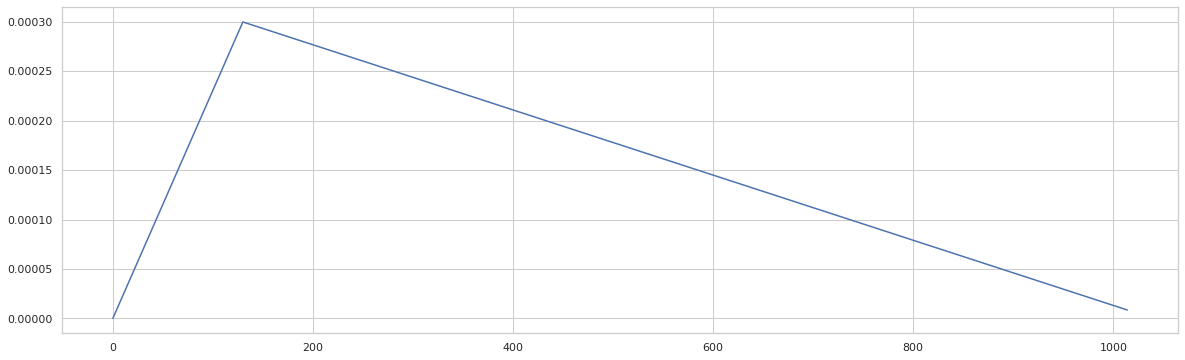

In [7]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [8]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(weights=config['BASE_MODEL_PATH'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [9]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
Epoch 1/40
24/24 - 38s - auc: 0.4921 - loss: 0.5325 - val_auc: 0.5210 - val_loss: 0.7157
Epoch 2/40
24/24 - 17s - auc: 0.5794 - loss: 0.1625 - val_auc: 0.6390 - val_loss: 0.2654
Epoch 3/40
24/24 - 17s - auc: 0.7976 - loss: 0.0783 - val_auc: 0.7076 - val_loss: 0.0986
Epoch 4/40
24/24 - 17s - auc: 0.8841 - loss: 0.0683 - val_auc: 0.7458 - val_loss: 0.0816
Epoch 5/40
24/24 - 13s - auc: 0.9131 - loss: 0.0613 - val_auc: 0.7184 - val_loss: 0.0839
Epoch 6/40
24/24 - 13s - auc: 0.9348 - loss: 0.0525 - val_auc: 0.7179 - val_loss: 0.0850
Epoch 7/40
24/24 - 13s - auc: 0.9586 - loss: 0.0462 - val_auc: 0.7359 - val_loss: 0.0863
Epoch 8/40
24/24 - 17s - auc: 0.9601 - loss: 0.0427 - val_auc: 0.7772 - val_loss: 0.0794
Epoch 9/40
24/24 - 13s - auc: 0.9749 - loss: 0.0349 - val_auc: 0.6646 - val_loss: 0.0977
Epoch 10/40
24/24 - 13s - auc: 0.9780 - loss: 0.0286 - val_auc: 0.7282 - val_loss: 0.0913
Epoch 11/40
24/24 - 13s - auc: 0.9814 - loss: 0.0256 - val_auc: 0.6320 - val_loss: 0.1130
Epoch 12/4

## Model loss graph

Fold: 0


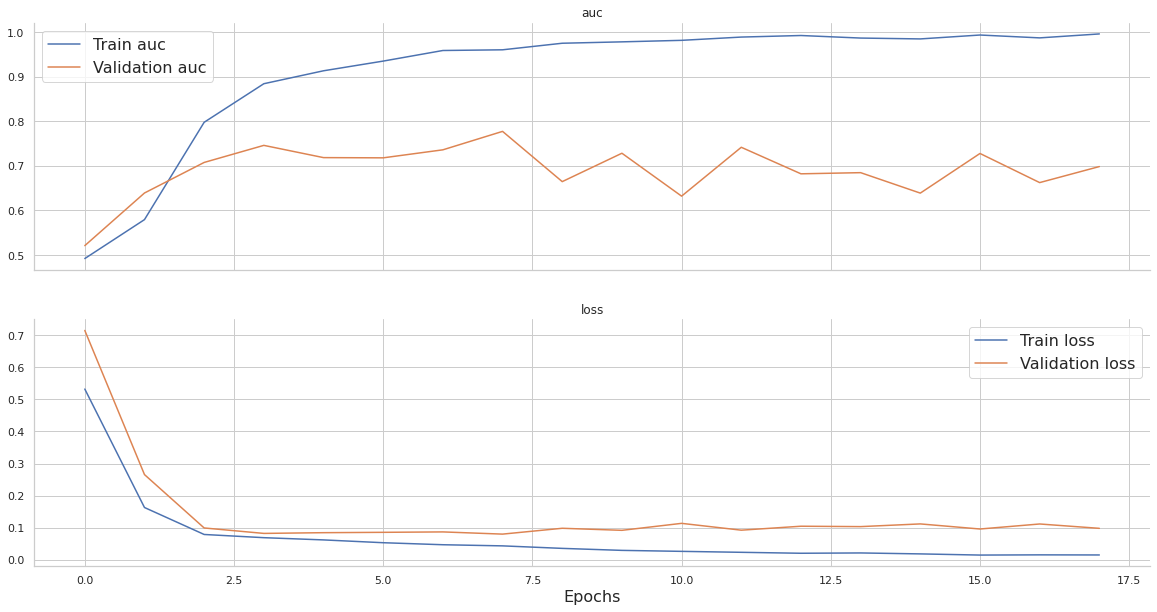

Fold: 1


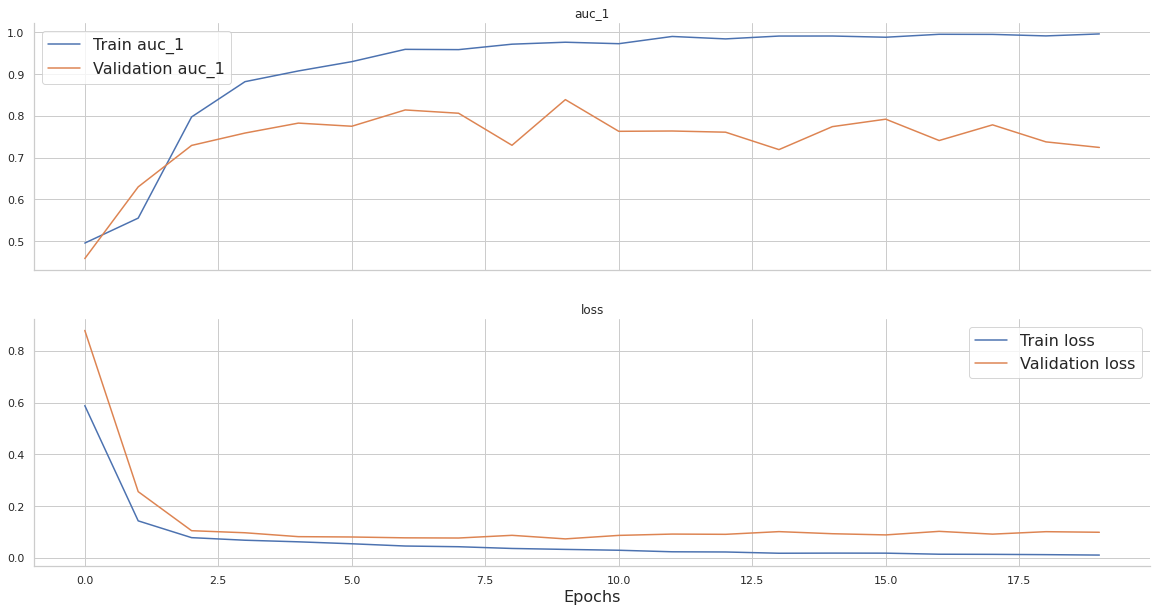

Fold: 2


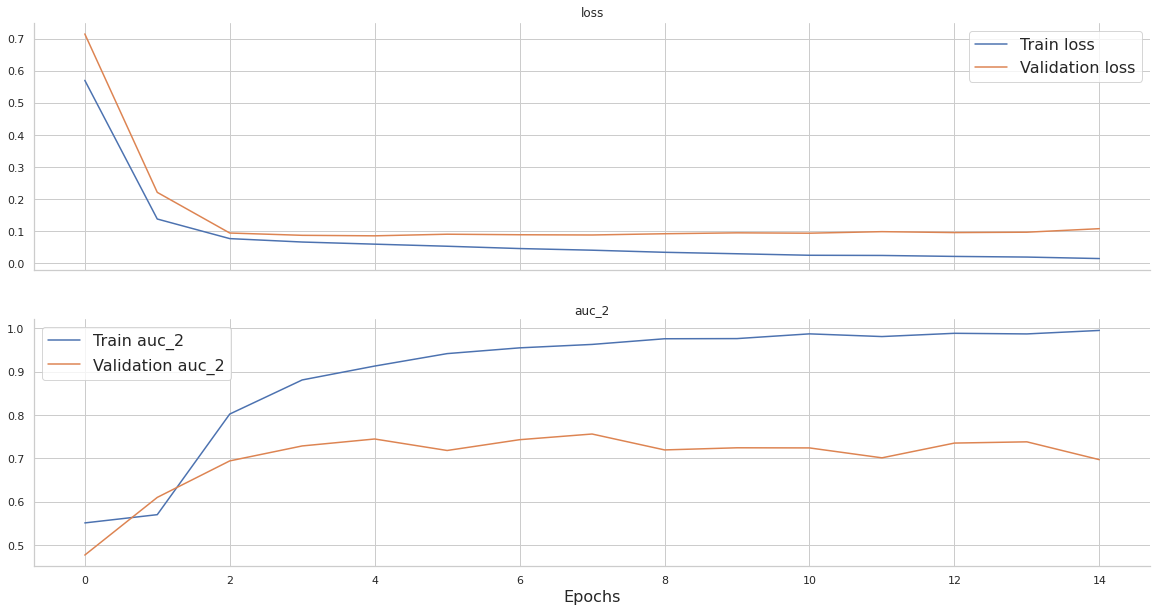

Fold: 3


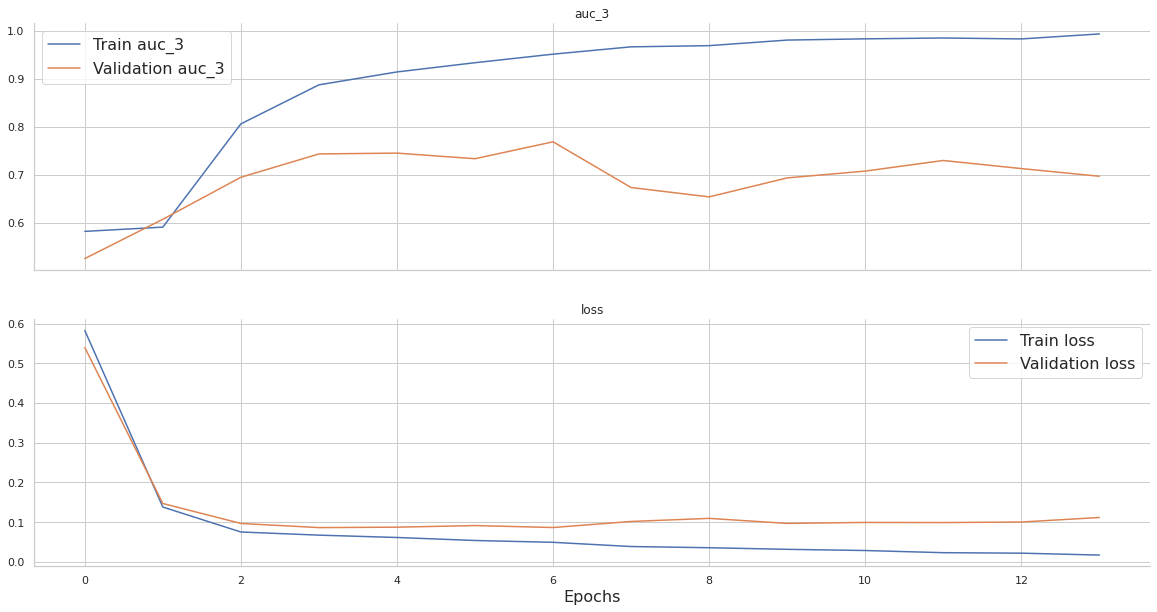

Fold: 4


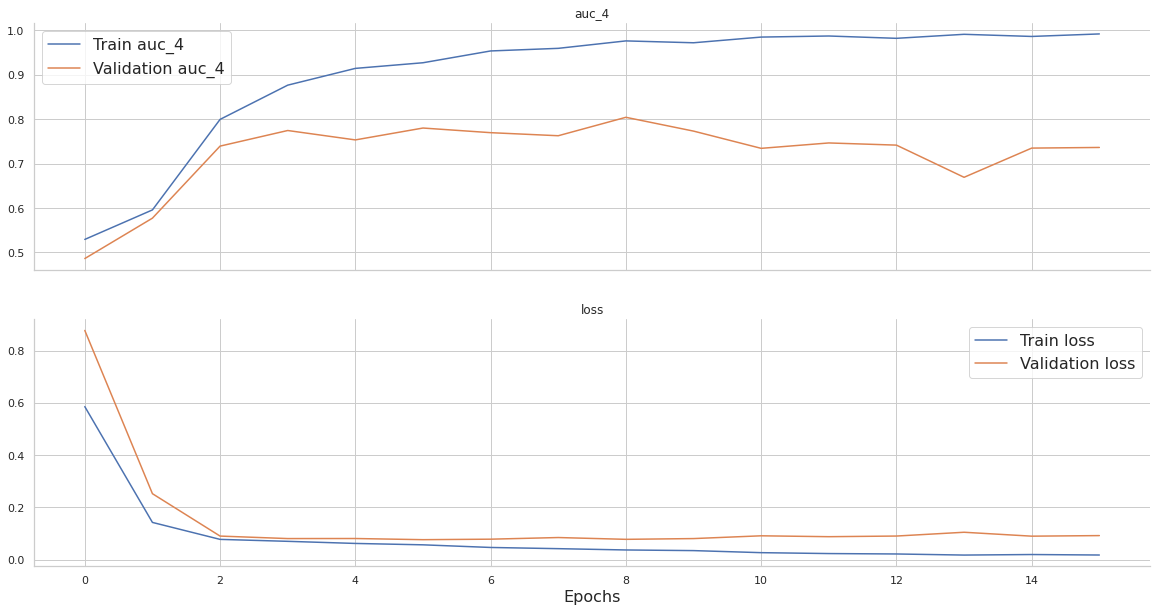

In [10]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold}')
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.889511,0.809916,0.079595,0.933303,0.845671,0.984937,0.884332,0.854549,0.764332,0.804501,0.752012,0.870264,0.803235
Accuracy,0.984366,0.982201,0.002165,0.983616,0.982014,0.990339,0.981651,0.982462,0.982134,0.982543,0.982105,0.982871,0.983100
Precision,0.695039,0.677949,0.017091,0.750000,0.166667,0.882143,0.423077,0.473684,1.000000,0.666667,1.000000,0.702703,0.800000
Recall,0.145040,0.035570,0.109470,0.121896,0.014184,0.521097,0.100000,0.019108,0.017699,0.008475,0.008929,0.054622,0.037037
F1-score,0.203943,0.062237,0.141706,0.209709,0.026144,0.655172,0.161765,0.036735,0.034783,0.016736,0.017699,0.101365,0.070796
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [12]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.889511,0.809916,0.079595,0.933303,0.845671,0.984937,0.884332,0.854549,0.764332,0.804501,0.752012,0.870264,0.803235
male,0.883746,0.796883,0.086863,0.933226,0.857561,0.985117,0.876318,0.838042,0.779038,0.797028,0.698583,0.865318,0.772914
female,0.897191,0.823123,0.074068,0.931000,0.826525,0.984529,0.896013,0.878608,0.727823,0.812017,0.820542,0.879798,0.844710
head/neck,0.860417,0.763716,0.096702,0.917537,0.885930,0.994049,0.844415,0.817226,0.718576,0.717403,0.694098,0.855871,0.675559
upper extremity,0.881919,0.796837,0.085082,0.924784,0.835333,0.976454,0.879159,0.838690,0.788538,0.795756,0.701568,0.873913,0.779588
lower extremity,0.886253,0.799769,0.086484,0.933495,0.778748,0.982265,0.811020,0.854828,0.795430,0.789235,0.802592,0.871441,0.811053
torso,0.895749,0.825842,0.069908,0.939689,0.870362,0.987231,0.934126,0.863272,0.739692,0.825426,0.749520,0.863128,0.835507
0 <= age < 26,0.916631,0.826412,0.090220,0.933475,0.894406,0.996412,0.841067,0.895783,0.815348,0.865491,0.767249,0.891995,0.813988
26 <= age < 40,0.887471,0.796290,0.091181,0.942130,0.875678,0.970397,0.864101,0.837264,0.833255,0.822813,0.666490,0.864753,0.741928


# Confusion matrix

Fold: 1


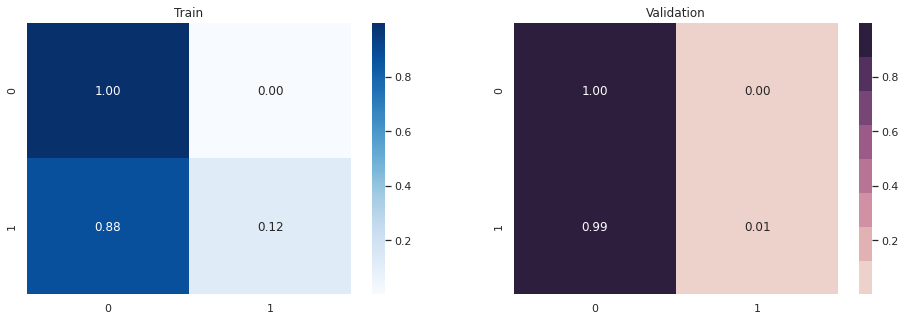

Fold: 2


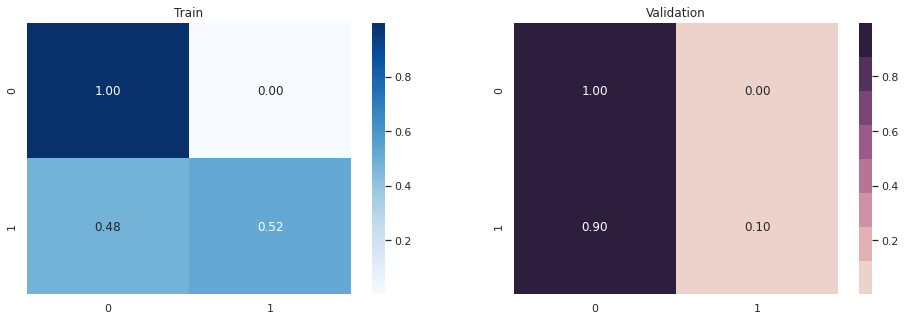

Fold: 3


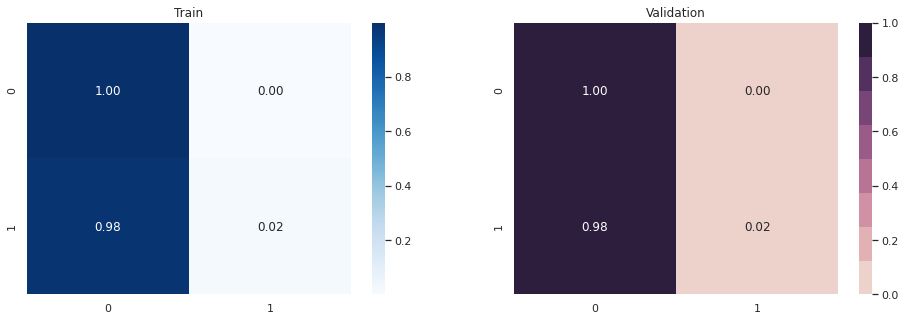

Fold: 4


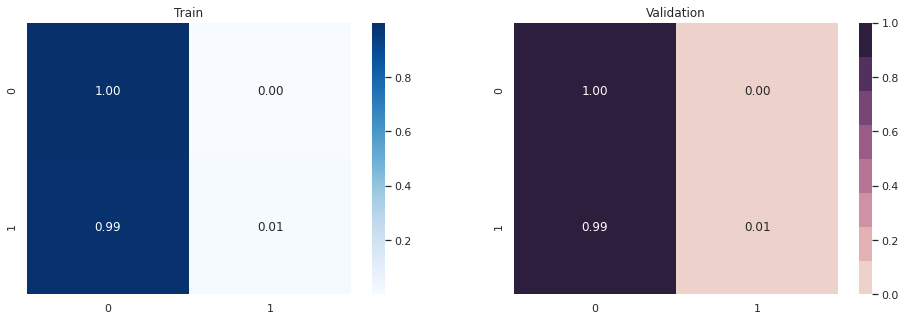

Fold: 5


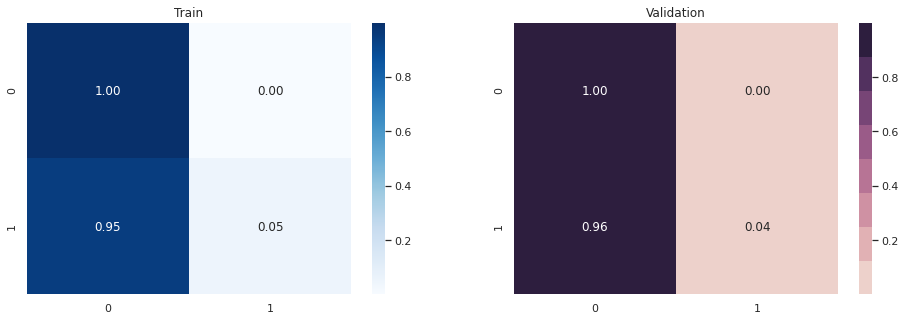

In [13]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    validation_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          validation_set['target'], np.round(validation_set[pred_col]))

# Visualize predictions

In [14]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred >= .5').head(10))

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.004333,0.002992,0.000959,0.003166,0.003600,0.010947
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.000656,0.000518,0.000010,0.000642,0.001079,0.001033
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.014759,0.001954,0.000521,0.022960,0.008417,0.039942
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.003492,0.000694,0.000064,0.002701,0.006499,0.007502
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.000483,0.000013,0.000015,0.000529,0.001452,0.000406
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.000369,0.000118,0.000018,0.000587,0.000812,0.000309
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.000482,0.000204,0.000099,0.000617,0.000941,0.000549
7,ISIC_0075663,female,35.0,torso,unknown,0,0.003080,0.000264,0.000519,0.007047,0.003907,0.003663
8,ISIC_0075914,male,30.0,torso,unknown,0,0.000898,0.000074,0.001765,0.000245,0.001781,0.000624
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.001027,0.000079,0.000117,0.000930,0.002557,0.001451


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.006469,0.000193,0.006204,0.004937,0.007608,0.013402
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.154248,0.035046,0.643018,0.048348,0.017889,0.026941
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.220202,0.046031,0.965597,0.021559,0.057158,0.010666
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.094022,0.003117,0.386884,0.025513,0.004611,0.049987
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.137389,0.110533,0.296652,0.147326,0.032937,0.099497
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.164697,0.017995,0.755628,0.023252,0.009320,0.017289
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.023207,0.020963,0.023814,0.035613,0.004361,0.031282
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.063307,0.005063,0.200255,0.008812,0.095201,0.007207
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.145089,0.204344,0.189218,0.119968,0.126691,0.085224
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.258708,0.366324,0.754201,0.071261,0.078259,0.023497


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.522917,0.841892,0.981563,0.234031,0.103914,0.453184
1691,ISIC_0610141,male,60.0,torso,unknown,0,0.603719,0.389164,0.674784,0.821952,0.424049,0.708645
3515,ISIC_1162337,male,45.0,palms/soles,melanoma,1,0.504311,0.894022,0.378627,0.497760,0.239752,0.511397
8623,ISIC_2685593,male,75.0,torso,melanoma,1,0.535644,0.855660,0.734192,0.210079,0.136038,0.742252
12155,ISIC_3738751,male,60.0,torso,melanoma,1,0.552241,0.782565,0.934410,0.318911,0.100776,0.624544
14767,ISIC_4523382,female,60.0,torso,melanoma,1,0.644996,0.859540,0.938235,0.351293,0.522447,0.553463
16797,ISIC_5137933,female,65.0,head/neck,melanoma,1,0.546103,0.807813,0.943856,0.335697,0.194317,0.448832
18417,ISIC_5602826,female,60.0,upper extremity,melanoma,1,0.569348,0.833246,0.989711,0.180319,0.191237,0.652229
18975,ISIC_5758388,female,45.0,torso,melanoma,1,0.635014,0.682229,0.943003,0.600187,0.401329,0.548319
19325,ISIC_5867911,male,55.0,upper extremity,melanoma,1,0.822058,0.961534,0.970422,0.796227,0.581279,0.800827
